## Load module

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

## Set parameter

In [45]:
pitch = 5  # reset y every 20 value
step = 2    
N = 100    # number of steps
n_train = int(N*0.7)  # number of training steps

def gen_data(x):            # generate data by mod
    return (x%pitch)/pitch  # normalize to [0,1]

t = np.arange(1,N+1)
# t = np.flip(t)  # reverse time
# y = [gen_data(x) for x in t]  # generate data list
y = gen_data(t)  # generate data numpy array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# create a numpy array from the list
def convertToMatrix(data, step=1):
    X, Y = [], []
    for i in range(len(data) - step):
        d = i + step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# Define train and test sets
train, test = y[:n_train], y[n_train:]
print('train test(before convertToMatrix):', train.shape, test.shape)

# Convert to matrix
X_train, y_train = convertToMatrix(train, step=step)
X_test, y_test = convertToMatrix(test, step=step)
print('train test(after convertToMatrix):', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train test(before convertToMatrix): (70,) (30,)
train test(after convertToMatrix): (68, 2) (68,) (28, 2) (28,)


## Create model

In [21]:
class MyRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.rnn(x)[0])
        return self.fc(x)  # output layer

In [ ]:
model = MyRNNModel(input_size=step, hidden_size=32, output_size=1)

criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=5e-2)

## Create train loader

In [54]:
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(0)

X_train_tensor = torch.from_numpy(X_train).float()  # Add batch dimension
y_train_tensor = torch.from_numpy(y_train).float() # .unsqueeze(0)

In [32]:
print(X_train_tensor.shape, y_train_tensor.shape)

torch.Size([68, 2]) torch.Size([68])


## Find best learning

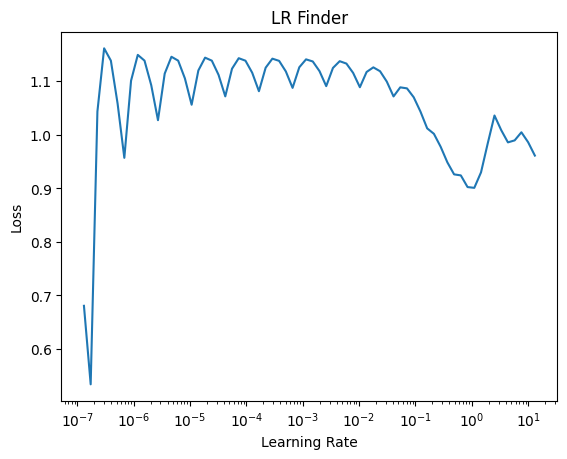

In [62]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1)

def find_lr(model, train_loader, loss_fn, optimizer_class=optim.Adam, 
            init_value=1e-7, final_value=10, beta=0.98):
    """Run a learning rate range test."""
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    avg_loss, best_loss = 0., float('inf')
    losses, log_lrs = [], []
    
    for batch_num, (inputs, targets) in enumerate(train_loader):
        # Move to GPU if available
        inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

        # Adjust learning rate
        lr *= mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Compute smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**(batch_num+1))
        
        # Record the lr and loss
        log_lrs.append(lr)
        losses.append(smoothed_loss)
        
        # Stop if the loss explodes
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break
        
        # Update best loss
        if smoothed_loss < best_loss or batch_num == 0:
            best_loss = smoothed_loss

        # Backprop
        loss.backward()
        optimizer.step()
    
    # Plot
    plt.plot(log_lrs, losses)
    plt.xscale('log')
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("LR Finder")
    plt.show()

# --- Example usage ---
# Assume you already have:
#   train_loader = DataLoader(train_dataset, batch_size=...)
#   loss_fn = nn.CrossEntropyLoss()

find_lr(model, train_loader, criterion)

In [64]:
model = MyRNNModel(input_size=step, hidden_size=32, output_size=1)

criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=5e-3)

## Train model

In [65]:
import time

start = time.time()

l1_lambda = 1e-4
l2_lambda = 1e-4

# Training loop
epochs = 30
for epoch in range(epochs):  # Train for 50 passes over the dataset
    model.train()  # 1️⃣ Put model in training mode (important for dropout/batchnorm)
    
    running_loss, correct = 0.0, 0  # Track total loss and correct predictions
    
    for i in range(len(X_train_tensor)):
        optimizer.zero_grad()  # 2️⃣ Zero the gradients before the backward pass
        output = model(X_train_tensor[i].unsqueeze(0))  # Forward pass (add batch dimension)
        loss = criterion(output, y_train_tensor[i])
        loss.backward()
        optimizer.step()  # 3️⃣ Update the weights
        running_loss += loss.item()

        # Calculate accuracy (for regression, we can consider a threshold)
        if torch.abs(output - y_train_tensor[i]).item() < 0.1:  #
            correct += 1

    # After the epoch
    epoch_loss = running_loss / len(X_train_tensor)  # Average loss over all samples
    epoch_acc = correct / len(X_train_tensor)        # Accuracy over all samples
    
    print(f"Epoch {epoch+1:02d}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")

end = time.time()

print(f'Time: {end-start:.3f} s')

Epoch 01: Loss=0.1142, Acc=0.1765
Epoch 02: Loss=0.0801, Acc=0.1912
Epoch 03: Loss=0.0715, Acc=0.2647
Epoch 04: Loss=0.0643, Acc=0.2941
Epoch 05: Loss=0.0599, Acc=0.1912
Epoch 06: Loss=0.0568, Acc=0.3824
Epoch 07: Loss=0.0535, Acc=0.3824
Epoch 08: Loss=0.0495, Acc=0.3971
Epoch 09: Loss=0.0444, Acc=0.3971
Epoch 10: Loss=0.0382, Acc=0.3971
Epoch 11: Loss=0.0316, Acc=0.3971
Epoch 12: Loss=0.0251, Acc=0.5294
Epoch 13: Loss=0.0191, Acc=0.5882
Epoch 14: Loss=0.0140, Acc=0.5882
Epoch 15: Loss=0.0098, Acc=0.5882
Epoch 16: Loss=0.0066, Acc=0.6176
Epoch 17: Loss=0.0043, Acc=0.8088
Epoch 18: Loss=0.0026, Acc=1.0000
Epoch 19: Loss=0.0015, Acc=1.0000
Epoch 20: Loss=0.0008, Acc=1.0000
Epoch 21: Loss=0.0004, Acc=1.0000
Epoch 22: Loss=0.0002, Acc=1.0000
Epoch 23: Loss=0.0001, Acc=1.0000
Epoch 24: Loss=0.0000, Acc=1.0000
Epoch 25: Loss=0.0000, Acc=1.0000
Epoch 26: Loss=0.0000, Acc=1.0000
Epoch 27: Loss=0.0000, Acc=1.0000
Epoch 28: Loss=0.0000, Acc=1.0000
Epoch 29: Loss=0.0000, Acc=1.0000
Epoch 30: Loss

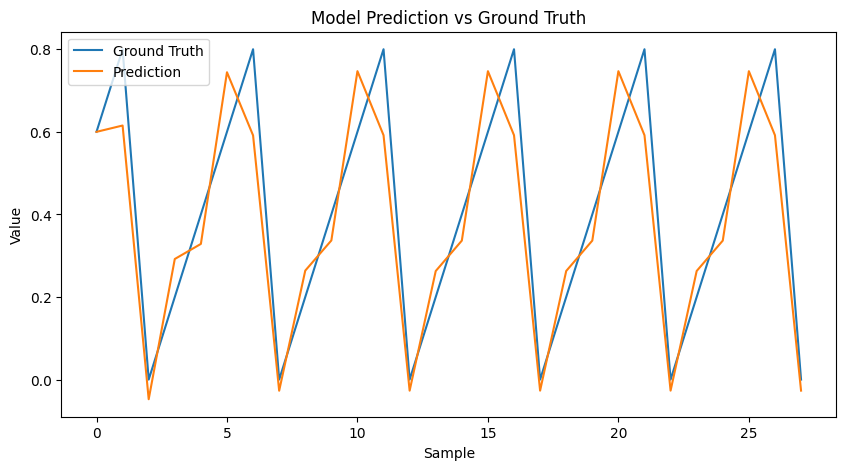

In [68]:
# Convert X_test to torch tensor and move to device
X_test_tensor = torch.from_numpy(X_test).float()

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Predict
    y_pred = model(X_test_tensor).numpy().flatten()

# Plot prediction vs ground truth
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Ground Truth')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Model Prediction vs Ground Truth')
plt.show()

# Sample Simple RNN

In [4]:
import torch
import torch.nn as nn

rnn = nn.RNN(input_size=3, hidden_size=2, batch_first=False)  
# hidden_size = number of hidden units

# Example input: seq_len=5, batch=4, features=3
xb = torch.randn(5, 4, 3)

output, hidden = rnn(xb)

print("Input shape:", xb.shape)       # (5, 4, 3)
print("Output shape:", output.shape)  # (5, 4, 2) → same seq_len & batch, hidden_size=2
print("Hidden shape:", hidden.shape)  # (1, 4, 2) → (num_layers, batch, hidden_size)

print("Input:", xb)
print("Output:", output)
print("Hidden state:", hidden)

Input shape: torch.Size([5, 4, 3])
Output shape: torch.Size([5, 4, 2])
Hidden shape: torch.Size([1, 4, 2])
Input: tensor([[[-0.3479,  1.3226,  0.5318],
         [ 0.7066,  0.4954,  0.1085],
         [-0.5981, -0.5986, -0.8757],
         [-0.4631,  0.1916, -0.2191]],

        [[ 0.6123, -1.7210,  0.8650],
         [ 1.9097,  0.6108, -0.3513],
         [-1.2417,  1.5635,  0.7767],
         [-1.7416,  0.6173,  1.0917]],

        [[-0.3474,  0.1675,  1.5160],
         [ 0.8196,  0.9686, -1.2354],
         [-1.5313,  2.2451,  1.1215],
         [-1.4490,  0.9629, -0.5913]],

        [[ 0.7830, -0.4924, -0.4089],
         [-1.0297, -0.4954, -0.3374],
         [-0.7513, -0.4148,  0.8992],
         [ 0.1864, -0.4977, -0.3369]],

        [[-1.5008,  0.8515, -0.6118],
         [ 0.9623,  0.9537, -0.9019],
         [ 0.1108,  0.8025, -0.0998],
         [ 2.5160, -1.1188,  1.1882]]])
Output: tensor([[[ 0.7584,  0.6163],
         [ 0.3205,  0.7500],
         [ 0.6586, -0.3000],
         [ 0.6742,  0